In [155]:
import io, time, json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sklearn
from tensorflow.keras.utils import to_categorical
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [156]:
# Grabbing the nominees
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL.

    Args:
        url (string): 

    Returns:
        result: dict, movie name as key, movie information as value
    """
    # remember to use browser header here, or cannot retrieve full data from the website
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    response = requests.get(url, headers = headers)
    html = response.content
    soup = BeautifulSoup(html,'lxml')

    result = {}
    for item in soup.find_all('div', {'class':'result-subgroup subgroup-awardcategory-chron'}):
        try:
            award_title = item.find('div',{'class':'result-subgroup-title'}).find('a',{'class':'nominations-link'}).contents[0]
            if award_title == 'ACTRESS IN A SUPPORTING ROLE':
                sub_groups = item.find_all('div',{'class':'result-details awards-result-actingorsimilar'}) 
                for sub in sub_groups:
                    sub_result = {}
                    film_title = sub.find('div',{'class':'awards-result-film-title'}).find('a',{'class':'nominations-link'}).contents[0]
                    is_winner = 1
                    actor = sub.find('div',{'class':'awards-result-nominationstatement'}).find('a',{'class':'nominations-link'}).contents[0]           
                    #character = sub.find('div',{'class':'awards-result-character-name'}).contents[0].strip('{}"')
                    sub_result['film_title'] = film_title
                    sub_result['is_winner'] = is_winner
                    sub_result['actor'] = actor
                    #sub_result['character'] = character
                    # sub_result['director'] = director
                    if sub.find('span',{'class':'glyphicon glyphicon-star'}):
                        sub_result['winner'] = 1
                    else:
                        sub_result['winner'] = 0
                    result[film_title] = sub_result
        except Exception:
            pass
    return result

In [157]:
# data of year 2016
best_2016 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:89,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2017
best_2017 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:90,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2018
best_2018 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:91,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

In [158]:
best_2018


{'Vice': {'film_title': 'Vice',
  'is_winner': 1,
  'actor': 'Amy Adams',
  'winner': 0},
 'Roma': {'film_title': 'Roma',
  'is_winner': 1,
  'actor': 'Marina de Tavira',
  'winner': 0},
 'If Beale Street Could Talk': {'film_title': 'If Beale Street Could Talk',
  'is_winner': 1,
  'actor': 'Regina King',
  'winner': 1},
 'The Favourite': {'film_title': 'The Favourite',
  'is_winner': 1,
  'actor': 'Rachel Weisz',
  'winner': 0}}

In [159]:
# Load Data
import numpy as np
import pandas as pd
# read from award
df_awards = pd.read_csv('database.csv', skiprows = 1, names=['year','ceremony','award','is_winner','winner','movieName','filmInfo'])
df_movies = pd.read_csv('movies.csv')
df_credits = pd.read_csv('credits.csv')
#df2018_movies = pd.read_csv('2018_best_picture_tmdb.csv')
df161718_movies = pd.read_csv('2016_2017_best_actresssupport_tmdb2.csv')


In [160]:
#View data
df_awards.tail()

,year,ceremony,award,is_winner,winner,movieName,filmInfo
9959,2015,88,Writing (Original Screenplay),1.0,1.0,Spotlight,Written by Josh Singer & Tom McCarthy
9960,2015,88,Writing (Original Screenplay),NaN,NaN,Straight Outta Compton,Screenplay by Jonathan Herman and Andrea Berlo...
9961,2015,88,Jean Hersholt Humanitarian Award,1.0,1.0,Debbie Reynolds,NaN
9962,2015,88,Honorary Award,1.0,1.0,Spike Lee,NaN
9963,2015,88,Honorary Award,1.0,1.0,Gena Rowlands,NaN


In [161]:
# append the data we scrapped to the df_awards
data = []
for k,v in best_2016.items():
    row = []
    row.append(['2016', 89, 'Actress in a Supporting Role', v['is_winner'],v['winner'], v['film_title'], v['actor']])
    data.append(row[0])
  
for k,v in best_2017.items():
    row = []
    row.append(['2017', 90, 'Actress in a Supporting Role', v['is_winner'],v['winner'], v['film_title'], v['actor']])
    data.append(row[0])

for k,v in best_2018.items():
    row = []
    row.append(['2018', 91, 'Actress in a Supporting Role', v['is_winner'],v['winner'], v['film_title'], v['actor']])
    data.append(row[0])
# pass the column name to the columns!!! Or there will be a runtime error
df_awards=df_awards.append(pd.DataFrame(data,columns=['year','ceremony','award','is_winner','winner','movieName','filmInfo']),ignore_index=True)
df_awards['year']= df_awards['year'].astype(int)
#df_all_awards['winner']= df_all_awards['winner'].astype(int)
df_awards.drop_duplicates(subset=['movieName','year','winner','award'], inplace=True, keep='last')
df_awards.to_csv('bestactress_20161718.csv')

In [162]:
# Data Manipulation
#Joining the dataframes
if 'title' in df_credits.columns: 
  df_credits = df_credits.drop('title',axis=1) 
df_credits_movies = df_credits.set_index('movie_id').join(df_movies.set_index('id'))

In [163]:
#df_credits_movies.dtypes
# Reset the data types and get the earliest date of release_date
#Convert released date to date format so we can use it later for our max, min date
df161718_movies['release_date'] = pd.to_datetime(df161718_movies['release_date'], format='%Y-%m-%d')
df_credits_movies = df_credits_movies.append(df161718_movies)
df_credits_movies['release_date'] = pd.to_datetime(df_credits_movies['release_date'], format='%Y-%m-%d')

#get the earliest release date from the dataset
min_year = min(df_credits_movies['release_date']) #1916-09-04
max_year = max(df_credits_movies['release_date']) #2017-02-03
print(min_year)
print(max_year)

1916-09-04 00:00:00
2018-12-25 00:00:00


In [164]:
df_credits_movies['released_year'] = df_credits_movies['release_date'].dt.year.fillna(0.0).astype(int)
df_credits_movies
#df_awards[df_awards['year']==2016]

,budget,cast,crew,genres,genres_new,homepage,keywords,movie_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,released_year
19995,237000000,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",NaN,en,Avatar,...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009
285,300000000,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",NaN,http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",NaN,en,Pirates of the Caribbean: At World's End,...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007
206647,245000000,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",NaN,en,Spectre,...,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015
49026,250000000,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",NaN,en,The Dark Knight Rises,...,2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012
49529,260000000,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",NaN,en,John Carter,...,2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012
559,258000000,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de...","[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",NaN,http://www.sonypictures.com/movies/spider-man3/,"[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",NaN,en,Spider-Man 3,...,2007-05-01,890871626,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,2007
38757,260000000,"[{""cast_id"": 34, ""character"": ""Flynn Rider (vo...","[{""credit_id"": ""52fe46db9251416c91062101"", ""de...","[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",NaN,http://disney.go.com/disneypictures/tangled/,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",NaN,en,Tangled,...,2010-11-24,591794936,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They're taking adventure to new lengths.,Tangled,7.4,3330,2010
99861,280000000,"[{""cast_id"": 76, ""character"": ""Tony Stark / Ir...","[{""credit_id"": ""55d5f7d4c3a3683e7e0016eb"", ""de...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,http://marvel.com/movies/movie/193/avengers_ag...,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",NaN,en,Avengers: Age of Ultron,...,2015-04-22,1405403694,141.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A New Age Has Come.,Avengers: Age of Ultron,

In [165]:
# Select movies that are in Outstanding Picture or Best Picture awards category -> df_picture_awards
#join df_credits_movies and df_awards by movie name (df_credits_movies.title = df_awards.movieName)
#before that, extract BEST PICTRUE from the df_awards
df_actress_awards = df_awards.loc[df_awards['award'].isin(['Actress in a Supporting Role'])]
df_actress_awards.reset_index(drop = True, inplace = True)
df_credits_movies = df_credits_movies.loc[df_credits_movies['status'].isin(['Released'])]
df_actress_awards
df_actress_awards[df_actress_awards['year']=='2016']
print("--------------")
print(df_actress_awards.columns)
print("--------------")
print(df_credits_movies.columns)


--------------
Index(['year', 'ceremony', 'award', 'is_winner', 'winner', 'movieName',
       'filmInfo'],
      dtype='object')
--------------
Index(['budget', 'cast', 'crew', 'genres', 'genres_new', 'homepage',
       'keywords', 'movie_id', 'original_language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'released_year'],
      dtype='object')


In [166]:
# Replace all the null value in ‘winner’ column with 1
# df_picture_awards['winner'].isnull().sum()
df_actress_awards['is_winner'].fillna(1,inplace = True)
df_actress_awards

,year,ceremony,award,is_winner,winner,movieName,filmInfo
0,1936,9,Actress in a Supporting Role,1.0,NaN,Beulah Bondi,The Gorgeous Hussy
1,1936,9,Actress in a Supporting Role,1.0,NaN,Alice Brady,My Man Godfrey
2,1936,9,Actress in a Supporting Role,1.0,NaN,Bonita Granville,These Three
3,1936,9,Actress in a Supporting Role,1.0,NaN,Maria Ouspenskaya,Dodsworth
4,1936,9,Actress in a Supporting Role,1.0,1.0,Gale Sondergaard,Anthony Adverse
5,1937,10,Actress in a Supporting Role,1.0,1.0,Alice Brady,In Old Chicago
6,1937,10,Actress in a Supporting Role,1.0,NaN,Andrea Leeds,Stage Door
7,1937,10,Actress in a Supporting Role,1.0,NaN,Anne Shirley,Stella Dallas
8,1937,10,Actress in a Supporting Role,1.0,NaN,Claire Trevor,Dead End
9,1937,10,Actress in a Supporting Role,1.0,NaN,Dame May Whitty,Night Must Fall


In [167]:
# join df_picture_awards with df_credits_movies
#cleaning names/punctuation
import re
Actress = [re.sub(r'[^\w\s]','',x) for x in df_actress_awards['filmInfo'].str.lower().str.strip().values]
df_actress_awards.loc[:,'Actress in a Supporting Role'] = Actress
df_credits_movies['Actress'] = df_credits_movies.cast.str.extract('({})'.format('|'.join(df_actress_awards['filmInfo'])), expand=False)
df_credits_movies['Actress'] = df_credits_movies['Actress'].str.lower()
#df_credits_movies = df_credits_movies[df_credits_movies['Actress'].notnull()]
# for Actr in Actress:
#     #df_credits_movies["B"][df_credits_movies['A'].str.contains("BULL")] = "Long"
# #     df_credits_movies["Actress"][df_credits_movies['cast'].str.contains(Actr)] = Actr
# #     print(df_credits_movies['Actress'])
#     df_credits_movies["Actress"] = ifelse(grepl(Actr, df_credits_movies['cast'], ignore.case = T), Actr, "Other")

#print(filtered_df)
# check the dataframe, we can see the string in movie_title now is valid
print(df_actress_awards)
# print(df_credits_movies['Actress'])

ValueError: Wrong number of items passed 2, placement implies 1

In [ ]:
# join the two tables, merge the data
df = df_actress_awards.merge(df_credits_movies, left_on='movie_title', right_on='movie_title', how='right')
df = df.reset_index(drop=True)
#drop the columns from award table
df.drop('homepage',axis = 1, inplace = True)
df.drop('year',axis = 1, inplace = True)
df.drop('award',axis = 1, inplace = True)
df.drop('movieName',axis = 1, inplace = True)
df.drop('filmInfo',axis = 1, inplace = True)
df.drop('ceremony',axis = 1, inplace = True)
df['is_winner'].fillna(0,inplace=True) #fill NA with 0
df
# Print master df to csv
#df.to_csv('masterList.csv', index=False)

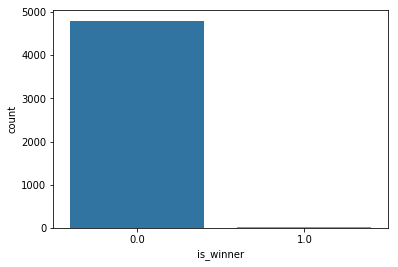

In [152]:
# We will choose the under-sampling by sampling from the 0-labeled data. 
# We need to first get a subset of nominated data, then sample from the non-nominated data, 
# and finally append the sampled data to the subset of nominated data.
sns.countplot(x='is_winner', data = df)


In [153]:
#Get the number of 0 labeled data, and the number of 1 labeled data
print(len(df.loc[df['is_winner'] == 0])) #4586
print(len(df.loc[df['is_winner'] == 1])) #209

4795
14


In [18]:
X_train = X[X["year"] < 2018]
X_test = X[X["year"] == 2018]

TypeError: '<' not supported between instances of 'str' and 'int'

In [15]:
X = df.drop("winner", axis=1)
y = df["winner"]
print(X.shape, y.shape)

(4821, 22) (4821,)


In [16]:
 #Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
# Fit the model to the data
classifier.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

In [ ]:
predictions = classifier.predict(X_test)

pd.DataFrame({"label": Actress[:20],"Prediction": predictions[:20], "Actual": y_test[:20]})

In [ ]:
# We will choose the under-sampling by sampling from the 0-labeled data. 
# We need to first get a subset of nominated data, then sample from the non-nominated data, 
# and finally append the sampled data to the subset of nominated data.
sns.countplot(x='winner', data = df)


In [ ]:
#Get the number of 0 labeled data, and the number of 1 labeled data
print(len(df.loc[df['winner'] == 0])) #4586
print(len(df.loc[df['winner'] == 1])) #209

In [ ]:
#balance the data
df_subset_0 = df.loc[df['winner'] == 0]
df_subset_1 = df.loc[df['winner'] == 1]

df_subset_0.drop('winner',axis=1,inplace=True)
df_subset_1.drop('winner',axis=1,inplace=True)

#sample with replacement
df_subset_0 = df_subset_0.sample(400) 
df_subset = pd.concat([df_subset_0,df_subset_1],ignore_index = True)
df_new = df_subset.merge(df_actress_awards, left_on = 'Actress', right_on = 'Actress', how = 'left')
df_new = df_new.fillna(0)

In [ ]:
print(len(df_new))

In [ ]:
sns.countplot(x='winner', data = df_new)

In [ ]:
#check number of null values in the dataset
df_new.isnull().sum()

In [ ]:
#Exploratory Data Analysis

# check the data types and select numeric variables
df_new.dtypes

In [ ]:
# correlation analysis
g = sns.heatmap(df_new[['budget','popularity','revenue','ceremony','vote_average','vote_count']].corr(),cmap='RdYlGn',annot=True)





In [ ]:
# Density Curve
# budget
budget0 = df_new[df_new['winner'] == 0]['budget']
budget1 = df_new[df_new['winner'] == 1]['budget']

g = sns.kdeplot(budget0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(budget1, legend = True, shade=True, color='b', label = 'nonminated')

In [ ]:
# revenue
# density curve
revenue0 = df_new[df_new['winner'] == 0]['revenue']
revenue1 = df_new[df_new['winner'] == 1]['revenue']

g = sns.kdeplot(revenue0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(revenue1, legend = True, shade=True, color='b', label = 'nonminated')

In [ ]:
# vote count
vc0 = df_new[df_new['winner'] == 0]['vote_count']
vc1 = df_new[df_new['winner'] == 1]['vote_count']

g = sns.kdeplot(vc0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(vc1, legend = True, shade=True, color='b', label = 'nonminated')

In [ ]:
# vote average
va0 = df_new[df_new['winner'] == 0]['vote_average']
va1 = df_new[df_new['winner'] == 1]['vote_average']

g = sns.kdeplot(va0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(va1, legend = True, shade=True, color='b', label = 'nonminated')

In [ ]:
# popularity
popularity0 = df_new[df_new['winner'] == 0]['popularity']
popularity1 = df_new[df_new['winner'] == 1]['popularity']

g = sns.kdeplot(popularity0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(popularity1, legend = True, shade=True, color='b', label = 'nonminated')

In [ ]:
#runtime
runtime0 = df_new[df_new['winner'] == 0]['runtime']
runtime1 = df_new[df_new['winner'] == 1]['runtime']

g = sns.kdeplot(runtime0, legend = True, shade=True, color='r', label = 'non-nominated')
g = sns.kdeplot(runtime1, legend = True, shade=True, color='b', label = 'nonminated')

In [ ]:
#genres
#clean the data
genres_name0 = {}
genres_name1 = {}
genres_set = set()
for i in range(len(df_new)):
    genres = json.loads(df_new.loc[i,'genres'])
    for it in genres:
        genres_set.add(it['name'])
        if df_new.loc[i,'winner'] == 0:
            if it['name'] not in genres_name0:
                genres_name0[it['name']] = 1
            else:
                genres_name0[it['name']] += 1
        if df_new.loc[i,'winner'] == 1:
            if it['name'] not in genres_name1:
                genres_name1[it['name']] = 1
            else:
                genres_name1[it['name']] += 1

genres_array0=[]
genres_array1=[]
for g in genres_set:
    if g in genres_name0:
        genres_array0.append(genres_name0[g])
    else:
        genres_array0.append(0)
    if g in genres_name1:
        genres_array1.append(genres_name1[g])
    else:
        genres_array1.append(0)


        
genres_all = []
genres_all.append(np.array(genres_array0)/sum(genres_array0))
genres_all.append(np.array(genres_array1)/sum(genres_array1))

In [ ]:
df_genres = pd.DataFrame(genres_all, columns=list(genres_set))
print(df_genres.head())

In [ ]:
# draw stacked bar chart
N = len(df_genres.columns)
ind = np.arange(N)
width = 0.5

plt.figure(figsize=(20,10))
p1 = plt.bar(ind, df_genres.loc[[0]].values[0], width, color='#d62728')
p2 = plt.bar(ind, df_genres.loc[[1]].values[0], width, bottom=df_genres.loc[[0]].values[0])

plt.ylabel('percentage (#genres/#movies)')
plt.title('Percentage by genres and nominations')
plt.xticks(ind,df_genres.columns)
plt.legend((p1[0],p2[0]),('Non-nominees','nominees'))

In [ ]:
# Feature Engineering
# Since many columns such as “crew”, “cast” contain information in json format, we need to extract useful information from the columns and then perform one hot encoding.
# We will transform our dataset into a all numeric matrix so that we can feed the data into our machine learning model.
# To look at the structure of column (eg.”cast”), we can use: df.loc[0,’cast’]
import json
def feature_engineering(column_name, df, json_name):
    """
    Args:
        column_name: the column name in the dataframe that contains a json file that needs to conduct feature engineering on
        df: dataframe that perform feature engineering on
        json_name: name in the json file that we want to extract
    
    Returns: new dataframe after feature engineering
    """
    
    name = {}

    for item in df[column_name]:
        group = json.loads(item)
        for it in group:
            if it[json_name] not in name:
                name[it[json_name]] = 1
            else:
                name[it[json_name]] += 1
    
    final = {}
    index = 0
    for k,v in name.items():
        if v > 1:
            final[k] = index
            index += 1
    np_item = np.zeros((len(df),len(final)))
    item_dict = {}
    row = 0
    for item in df[column_name]:
        group = json.loads(item)
        for it in group:
            if it[json_name] in final:
                index = final[it[json_name]]
                np_item[row][index] = 1
        row += 1

    df_item = pd.DataFrame(np_item, columns = list(final.keys()))
    df_output = pd.concat([df,df_item],axis = 1)
    
    return df_output

In [ ]:
df2 = feature_engineering("cast", df_new, "name")
df2 = df2.drop('cast', axis = 1) #drop the column after feature engineering
df2

In [ ]:
# director
cast_name = {}

for item in df2['Actress']:
    if item not in cast_name:
        cast_name[item] = 1
    else:
        cast_name[item]+=1


# set the appear tims for actors
final_crew = {}
index = 0
for k,v in cast_name.items():
    if v > 0:
        final_crew[k] = index
        index += 1
# print(len(final_crew))

np_crew = np.zeros((len(df2), len(final_crew)))
row = 0
for item in df2['Actress']:
    if item not in final_crew:
        index = final_crew[item]
        np_crew[row][index] = 1
    else:
        cast_name[item]+=1
    row += 1

df_crew = pd.DataFrame(np_crew, columns = list(final_crew.keys()))
            
df3 = pd.concat([df2, df_crew], axis = 1)
# print(df.shape)

In [ ]:
# df_clean = df3
df3=df3.drop(['crew'],axis=1)
genres
df4 = feature_engineering("genres", df3, "name")
df4 = df4.drop(['genres'], axis = 1)
#keywords
df5 = feature_engineering('keywords', df4, 'name')
df5 = df5.drop(['keywords'], axis = 1)
#production_companies
df6 = feature_engineering('production_companies',df5,'name')
df6 = df6.drop(['production_companies'],axis=1)
#production_countries
df7 = feature_engineering('production_countries',df6,'name')
df7 = df7.drop(['production_countries'],axis=1)
#spoken_languages
df8 = feature_engineering('spoken_languages',df7,'iso_639_1')
df8 = df8.drop(['spoken_languages'],axis=1)

# # drop the columns not used
# df8
#df_clean = df8.drop(["movie_title","original_title","overview","tagline",'title','original_language','status','release_date','movieName','filmInfo','award'],axis=1)

In [ ]:
list(df8)

In [ ]:
#'Actress', 'budget', 'original_language', 'popularity', 'release_date', 'revenue', 'vote_average', 'vote_count', 'year', 'winner', 'movieName', 
df_clean = df8.drop([
    'Actress',
    'original_language',
    'release_date',
    'movieName',
 'original_title',
    'status',
 'tagline',
 'title',
 'overview',
 'runtime',
 'ceremony',
 'award','Nominis'],axis=1)

df_clean.head()

In [ ]:
print(df_clean['winner'])

In [ ]:
# Model Training
# split
X = df_clean[df_clean.columns.difference(['winner'])]
print(list(df_clean))

#X = StandardScaler().fit_transform(X)
y = df_clean['winner']
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=1/7.0, random_state=0)
print(X_train)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.85)
fit = pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# X_test = pca.transform(X_test)
# pca = PCA(n_components = 3)
# fit = pca.fit_transform(X)
# fit2 = pca.fit(X)
# print("Explained Variance: %s" % pca.explained_variance_ratio_) 
# print(fit)

In [ ]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
# For small datasets, ‘liblinear’ is a good choice
logisticRegr = LogisticRegression(solver = 'liblinear')
logisticRegr.fit(X_train, y_train)

In [ ]:
# Predict for One Observation
predicted = logisticRegr.predict(X_test)
print(logisticRegr.predict(X_test))
# print(y_test)
# df8['movie_title'][y_test.index]

In [ ]:
logisticRegr.score(X_test, y_test) # 0.8850574712643678

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
sensitivity = tp/(tp+fn)
# print(tp)
# print(fn)
print(sensitivity) # 0.84375

In [ ]:
#### Improvement: Cross Validation
# 3-fold Cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
sumAccuracy = []
for train,test in skf.split(X,y):
#     logisticRegr.fit(df_clean.iloc[train][], )
    df_train = df_clean.iloc[train]
    df_test = df_clean.iloc[test]
    train_X = df_train[df_clean.columns.difference(['winner'])]
    train_y = df_train['winner']
    test_X = df_test[df_clean.columns.difference(['winner'])]
    test_y = df_test['winner']
    logisticRegr.fit(train_X, train_y)
    sumAccuracy.append(logisticRegr.score(test_X, test_y))
avg = np.mean(sumAccuracy)
print(avg) # 0.7803837953091683
#print(df_clean.iloc[train,df_clean.columns.difference(['winner'])])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))